# PyTorch Custom Datasets

In the previous notebooks, we looked at how to build computer vision models on an in-built dataset in PyTorch (CIFAR10/ FashionMNIST).

The steps we took are similar across many different problems in machine learning.

Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction.

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own **custom dataset**.

## What is a custom dataset?

A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a **custom dataset** can be comprised of almost anything.

For example, if we were building a food image classification app like [Nutrify](https://nutrify.app), our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

## What we're going to cover

We're going to be applying the PyTorch Workflow to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. |
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.8.0+cu126'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

First things first—we need some data.

And like any good project, you should start with something small and manageable.

We’re not aiming to train the biggest model or use a massive dataset right away.
Machine learning is an iterative process: start small, get something working, and scale up only when needed.

For this tutorial, we’ll work with a dataset you prepare yourself.

👉 What to do:

Collect images for the classes you want to recognize.

Organize them into folders, one folder per class (e.g., dataset/cats/, dataset/dogs/, etc.).

Make sure each folder has a reasonable number of images (even 20–50 per class is enough to start experimenting).

Keep a separate set of images aside for testing/validation.

This folder-per-class structure is the most common way to prepare datasets for image classification tasks.

💡 Note: In real projects, you’ll often need to format, clean, and label your datasets manually. Pre-formatted datasets exist, but being able to handle your own data is an essential skill in machine learning.

## Structure of our data folder

For this exercise, we’ll keep the following folder structure:

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig47.png)

This is a straightforward folder structure with a root folder as the Train/Test folders containing classes with images inside them.

*However, some other dataset, as you’ll see in the future, might have a slightly different structure. It doesn’t matter in what structure we get the data in. The data can all be in a single folder with class names in the image names (like “Cat_001.jpg”) or even in a CSV, we can process all this in our custom dataset class.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Setup path to data folder
image_path = "/content/drive/MyDrive/gesture"

In [9]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/drive/MyDrive/gesture'.
There are 2 directories and 0 images in '/content/drive/MyDrive/gesture/test'.
There are 0 directories and 5 images in '/content/drive/MyDrive/gesture/test/thumbsUp'.
There are 0 directories and 5 images in '/content/drive/MyDrive/gesture/test/peace'.
There are 2 directories and 0 images in '/content/drive/MyDrive/gesture/train'.
There are 0 directories and 14 images in '/content/drive/MyDrive/gesture/train/peace'.
There are 0 directories and 19 images in '/content/drive/MyDrive/gesture/train/thumbsUp'.


Excellent!

It looks like we've got about 75 images per training class and 25 images per testing class.

Now let's visualize a random data from the dataset.

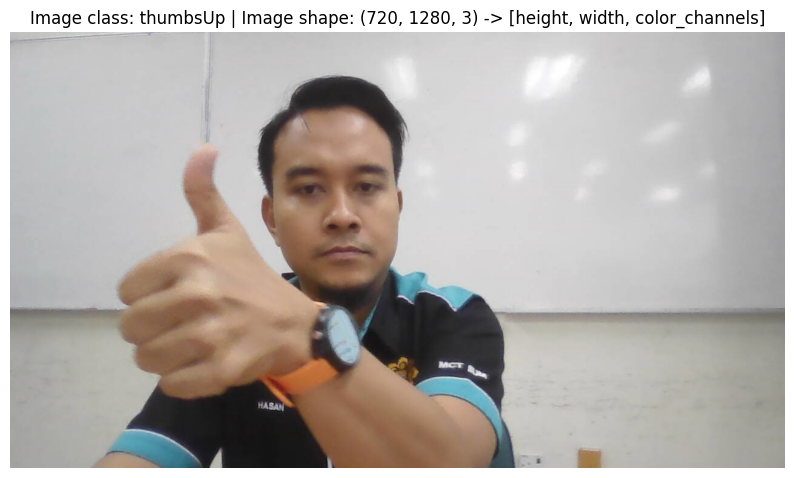

In [16]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

# Set seed
random.seed(42)

# Define the root directory where your dataset is stored
# Example: "data/food101/images"
image_path = Path(image_path)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))  # adjust pattern if needed

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)
plt.show()


##Loading Image Using Custom Dataset in Pytorch

You can call your dataset using the built-in function from pytorch. But what if a pre-built `Dataset` creator like [`torchvision.datasets.ImageFolder()`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own.

But wait, what are the pros and cons of creating your own custom way to load `Dataset`'s?

| Pros of creating a custom `Dataset` | Cons of creating a custom `Dataset` |
| ----- | ----- |
| Can create a `Dataset` out of almost anything. | Even though you *could* create a `Dataset` out of almost anything, it doesn't mean it will work. |
| Not limited to PyTorch pre-built `Dataset` functions. | Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues. |

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch).

We'll start by importing the modules we need:
* Python's `os` for dealing with directories (our data is stored in directories).
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
* `torch` for all things PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add type hints to our code.

> **Note:** You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

In [17]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### Creating a helper function to get class names
We can’t use the class names directly for models. We create mappings of classes to index and index to classes.

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

In [18]:
# Setup path for target directory
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
classes = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names: {classes}")

Target directory: /content/drive/MyDrive/gesture/train
Class names: ['peace', 'thumbsUp']


In [19]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'peace': 0, 'thumbsUp': 1}

### Create a custom `Dataset` to replicate `ImageFolder`

This is the core of our custom dataset. The structure of the dataset class is something like this:

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig48.png)

We create our customDataset class by inheriting the Dataset class:

>from torch.utils.data import Dataset

First, we define the **init** function. As soon as we create an instance of our customDataset class, this function is called by default. This function should contain all operations that we want to run on the whole dataset (eg. train) once. For now, we define the variables for image_paths and transforms for the corresponding Train and Test sets.

Then we have the **len** function which just returns the number of samples in the dataset. This is used afterward by the DataLoader to create batches.

And finally, we have **getitem**. This processes and returns 1 sample at a time.

In [20]:
from torch.utils.data import Dataset

#######################################################
#               Define Dataset Class
#######################################################

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = self.paths = list(pathlib.Path(image_paths).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath) # if using torchvision transforms

        # label = image_filepath.split('/')[-2]
        label = self.image_paths[idx].parent.name # expects path in data_folder/class_name/image.jpeg

        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image) # if using torchvision transforms

        return image, label

Before we test out our new `CustomDataset` class, let's create some transforms to prepare our images.

In [21]:
# Define transformations
data_transform = transforms.Compose(
    [transforms.Resize((224,224)), # Note the difference here compared to before
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

Now comes the moment of truth!

Let's turn our training images (contained in `train_dir`) and our testing images (contained in `test_dir`) into `Dataset`'s using our own `CustomDataset` class.

In [22]:
#######################################################
#                  Create Dataset
#######################################################

train_data_custom = CustomDataset(image_paths = train_dir, transform = data_transform)
test_data_custom = CustomDataset(image_paths =test_dir,transform = data_transform)

Let's try calling `len()` on our new `Dataset`'s and find the `classes` and `class_to_idx` attributes.

In [23]:
len(train_data_custom), len(test_data_custom)

(33, 10)

### Turn custom loaded images into `DataLoader`'s

We've got a way to turn our raw images into `Dataset`'s (features mapped to labels or `X`'s mapped to `y`'s) through our `CustomDataset` class.

Now how could we turn our custom `Dataset`'s into `DataLoader`'s?

If you guessed by using `torch.utils.data.DataLoader()`, you'd be right!

Because our custom `Dataset`'s subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

And we can do using very similar steps to before except this time we'll be using our custom created `Dataset`'s.

In [35]:
#######################################################
#                  Create Dataloader
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=4,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data


In [26]:
train_data_size = len(train_dataloader_custom.dataset)
test_data_size = len(test_dataloader_custom.dataset)

print(train_data_size)
print(test_data_size)

33
10


Do the shapes of the samples look the same?

In [27]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 4, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([4, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([4])


This is what we use to batch out the data in our training loop. Every time we run the iterator, the dataloader selects the next `batch_size indexes` and runs it through the __getitem__ in dataset class one by one and then returns it to the training loop.

In [30]:
model = models.resnet18(pretrained=True)
model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

# LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
import torch
from torchvision import models
from torchsummary import summary

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [33]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    # accuracy = torchmetrics.Accuracy(device=device)
    # Initialize the accuracy metric from torchmetrics
    # accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10).to(device)

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

    return best_model, history

In [36]:
# Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 0.5266, Accuracy: 75.7576%, 
		Validation : Loss : 0.3797, Accuracy: 90.0000%, Time: 27.5207s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.2655, Accuracy: 90.9091%, 
		Validation : Loss : 0.1714, Accuracy: 100.0000%, Time: 1.5293s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.0894, Accuracy: 100.0000%, 
		Validation : Loss : 0.0888, Accuracy: 100.0000%, Time: 1.0655s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.0785, Accuracy: 100.0000%, 
		Validation : Loss : 0.0541, Accuracy: 100.0000%, Time: 0.7650s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.4519, Accuracy: 84.8485%, 
		Validation : Loss : 0.0685, Accuracy: 100.0000%, Time: 0.7723s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2099, Accuracy: 90.9091%, 
		Validation : Loss : 0.4472, Accuracy: 70.0000%, Time: 0.7401s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3636, Accuracy: 84.8485%, 
		Validation : Loss : 0.1716, Accuracy: 90.0000%, Time: 0.7319s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0105, Accura

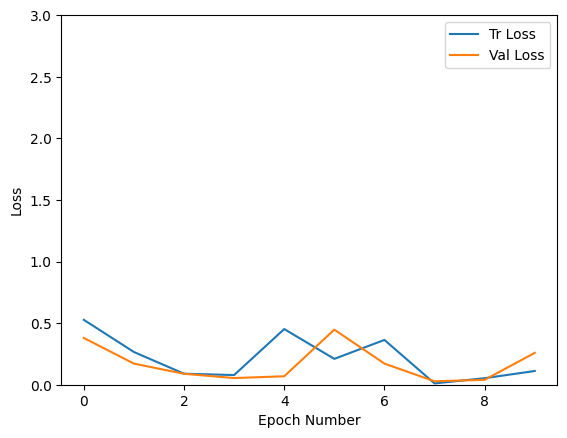

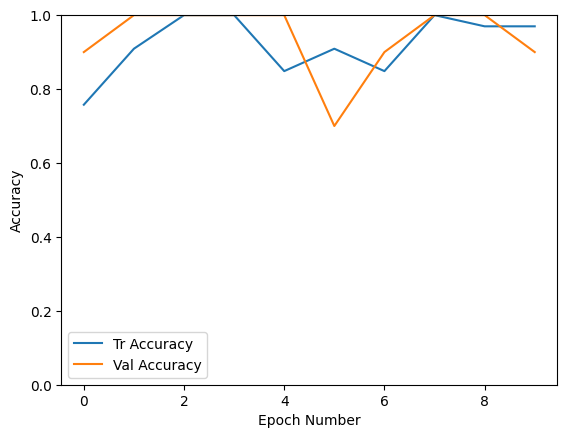

In [37]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

## Inference on webcam

In [ ]:
import cv2
import torch
import torchvision.transforms as transforms

# load the model
model = torch.load("name-of-your-model.pt", map_location=torch.device("cpu"))
model.eval()
model.to('cpu')

# assign label according to your custom classes
class_labels = ['class1', 'class2',...,'classN']

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
        ])

# reading the image
capture = cv2.VideoCapture(1)

while True:

    isTrue, frame = capture.read()

    image = frame.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    image = image.unsqueeze(0) # add batch dimension

    # feedforward/ inference
    with torch.no_grad():
        output = model(image)

    # postprocess output/ label
    _,predicted_class = output.max(1)
    predicted_class = predicted_class.item()

    predicted_class_name = class_labels[predicted_class]
    print(predicted_class_name)

    # label = f"Class: {predicted_class}"
    cv2.putText(frame,predicted_class_name,(10,50),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2)

    cv2.imshow('myVideo', frame)

    cv2.waitKey(1)


capture.release()
out.release()

cv2.destroyAllWindows()

